Number of objects found: 300


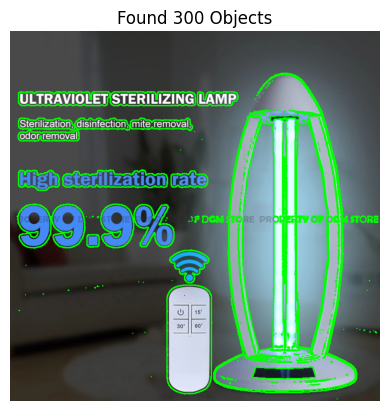

In [6]:
# 1. Contours (Finding Objects)
# Intuition: A contour is simply the outline of a shape.

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare Binary Image
img = cv2.imread("dataset/img/light.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(gray, (5,5), 0)

thresh = cv2.adaptiveThreshold(
    blur, 
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    9,
    2
)

# 2. Find Contours
# contours: a list of all shapes found
# hierarchy: info about which shape is inside which (parent/child)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 3. Use the Contours
print(f"Number of objects found: {len(contours)}")

# Create a copy to draw on
output_img = img.copy()

# Draw ALL contours (-1 means all, color is BGR, thickness is 2)
cv2.drawContours(output_img, contours, -1, (0, 255, 0), 2)

# 4. Show Result
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title(f"Found {len(contours)} Objects")
plt.axis('off')
plt.show()

cv2.imshow("Contours", output_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


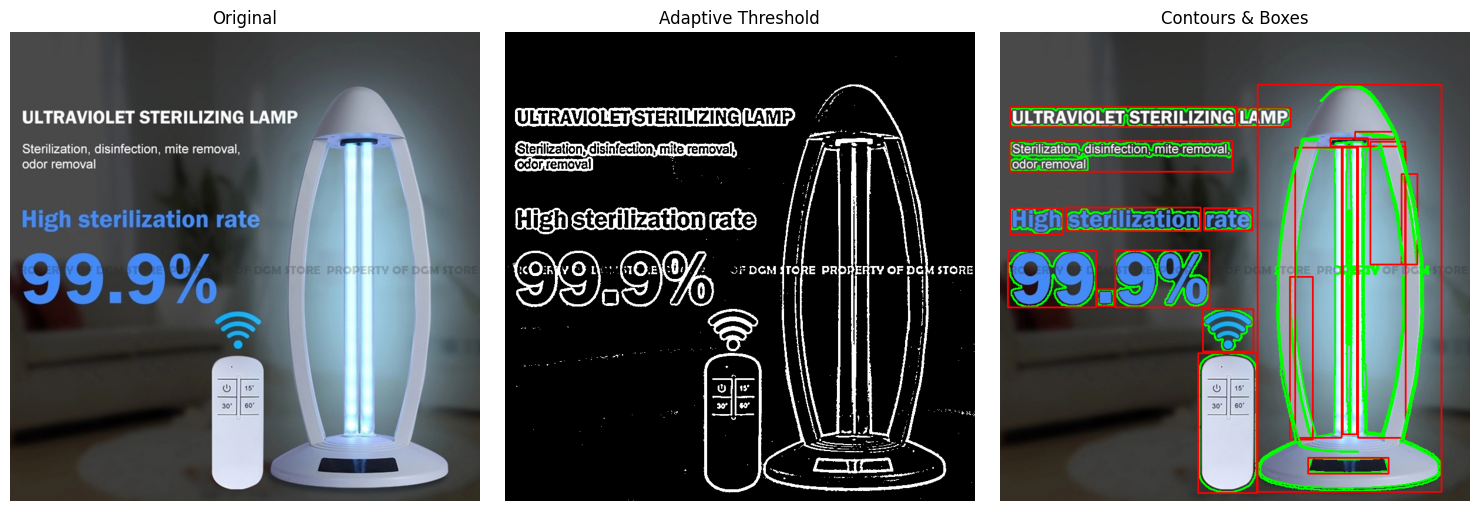

In [ ]:
# 2. Bounding Boxes & Area Filtering
# Intuition: Contours give outlines. Bounding boxes give position and size.

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Load and Prepare
img = cv2.imread("dataset/img/light.jpg")
if img is None:
    # Creating a sample image with a shadow gradient for demonstration
    img = np.zeros((400, 600, 3), dtype="uint8")
    cv2.rectangle(img, (0, 0), (600, 400), (200, 200, 200), -1) # Light gray bg
    cv2.circle(img, (300, 200), 50, (50, 50, 50), -1)           # Dark object
    # Adding a fake shadow
    img[:, 300:] = img[:, 300:] // 2

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Gaussian Blur (The 'Cleaner')
# Removes small specs that could become tiny "fake" contours
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 3. Adaptive Threshold (The 'Illuminator')
# This handles the shadows better than Global/Otsu
# Parameters: Source, MaxVal, Method, Type, BlockSize (must be odd), C (constant)
thresh = cv2.adaptiveThreshold(blurred, 255, 
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY_INV, 11, 2)

# 4. Find Contours
# We use RETR_EXTERNAL to ignore holes inside the objects
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 5. Filter and Draw
output = img.copy()
for cnt in contours:
    # Filter by area: Ignore objects smaller than 100 pixels (noise)
    if cv2.contourArea(cnt) > 150:
        # Draw the actual contour line (Green)
        cv2.drawContours(output, [cnt], -1, (0, 255, 0), 2)
        
        # Get and draw a Bounding Box (Red)
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), 2)

# --- Visualisation ---
plt.figure(figsize=(15, 5))
titles = ['Original', 'Adaptive Threshold', 'Contours & Boxes']
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB), thresh, cv2.cvtColor(output, cv2.COLOR_BGR2RGB)]

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray' if i==1 else None)
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
# 3. Shape Detection

import cv2

img = cv2.imread("dataset/img/uvc.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

contours, hierarchy = cv2.findContours(
    thresh,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

cv2.drawContours(img, contours, -1, (0,255,0), 2)

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 500:

        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)

        corners = len(approx)

        if corners == 3:
            shape = "Triangle"
        elif corners == 4:
            shape = "Rectangle"
        elif corners > 6:
            shape = "Circle"
        else:
            shape = "Unknown"

        x,y,w,h = cv2.boundingRect(cnt)
        cv2.putText(img, shape, (x,y-10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (255,0,0), 2)


cv2.imshow("Contours", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [20]:
# 4. FPS Measurement:
# Contour pipeline: Noise Removal → Threshold → Contours → Filter → Measure

import cv2
import time

cap = cv2.VideoCapture(0)
prev_time = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    thresh = cv2.adaptiveThreshold(
        blur, 
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        9,
        2
    )
    
    contours, _ = cv2.findContours(
        thresh,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 1000:

            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)

    # FPS
    current_time = time.time()
    fps = 1/(current_time-prev_time) if prev_time!=0 else 0
    prev_time = current_time

    cv2.putText(frame,f"FPS:{int(fps)}",(10,30),
                cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),2)

    cv2.imshow("Detection", frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


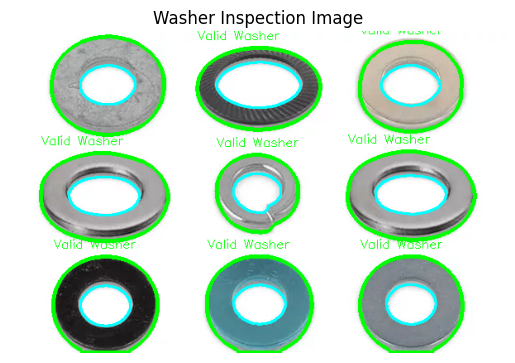

In [16]:
#### REAL WORLD EXAMPLES ####

# 1. Contour Hierarchy
# Real-world use: Detect objects with holes (washers, gears, rings)
# Best condition: Picture of coins or washers on a table

import cv2
import numpy as np

# Load image of washers
img = cv2.imread("dataset/img/washer5.jpg")
# If file doesn't exist, we create a dummy "Washer" (White ring on black)
if img is None:
    img = np.zeros((400, 400, 3), dtype="uint8")
    cv2.circle(img, (200, 200), 100, (255, 255, 255), -1) # Outer
    cv2.circle(img, (200, 200), 40, (0, 0, 0), -1)       # Hole

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (19, 19), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# RETR_TREE is mandatory to get the parent-child relationship
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# hierarchy[0] contains: [Next, Previous, First_Child, Parent]
hierarchy = hierarchy[0] 

for i in range(len(contours)):
    parent_idx = hierarchy[i][3]
    child_idx = hierarchy[i][2]

    # CASE 1: This is an Outer Shape (No Parent)
    if parent_idx == -1:  # Logic: "If I am an outer object..."  
        # Check if it has a child (a hole)
        if child_idx != -1:  # "...and I have something inside me..."
            color = (0, 255, 0) # Green: It's a valid washer (Circle + Hole).
            label = "Valid Washer"
        else:
            color = (0, 0, 255)  # Red: It's a defect (Solid disk, no hole).
            label = "Defect: No Hole"
        
        cv2.drawContours(img, [contours[i]], -1, color, 3)
        x, y, w, h = cv2.boundingRect(contours[i])
        cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # CASE 2: This is a Hole (Has a Parent)
    else:
        # Draw holes in Yellow to distinguish them
        cv2.drawContours(img, [contours[i]], -1, (0, 255, 255), 2)

plt.imshow(img)
plt.title("Washer Inspection Image")
plt.axis('off') # Hide axes
plt.show()

cv2.imshow("Washer Inspection", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
# 2. Contour Moments (Finding Center)
# Real-world use: Robot arm picking center of object
# Best condition: Webcam with one object on table

import cv2

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray, (15,15), 0)

    thresh = cv2.adaptiveThreshold(
        blur, 
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        19,
        5
    )
    cv2.imshow("Original", thresh)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        if cv2.contourArea(cnt) > 3000:
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"]/M["m00"])
                cy = int(M["m01"]/M["m00"])
                cv2.circle(frame,(cx,cy),5,(0,0,255),-1)
            
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)

    cv2.imshow("Centroid", frame)
    if cv2.waitKey(1) == 27:
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
# 3. Rotated Bounding Box
# Real-world use: Detect orientation of rectangular objects
# Best condition: Picture of a tilted book or phone

import cv2
import numpy as np

img = cv2.imread("dataset/img/box.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray,120,255,cv2.THRESH_BINARY_INV)

contours,_ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    if cv2.contourArea(cnt)>1000:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int32(box)
        cv2.drawContours(img,[box],0,(255,0,0),2)

cv2.imshow("Rotated Box",img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [104]:
# 4. Minimum Enclosing Circle
# Real-world use: Ball tracking
# Best condition: Webcam with a round object

import cv2

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray,120,255,cv2.THRESH_BINARY)

    contours,_ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        if cv2.contourArea(cnt)>1000:
            (x,y),radius = cv2.minEnclosingCircle(cnt)
            cv2.circle(frame,(int(x),int(y)),int(radius),(0,255,0),2)

    cv2.imshow("Circle Detection",frame)
    if cv2.waitKey(1)==27:
        break

cap.release()
cv2.destroyAllWindows()



In [138]:
# 5. Convex Hull
# Real-world use: Hand outline detection
# Best condition: Webcam, hand in front of plain background

import cv2

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    _, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel=np.ones((3,3),np.uint8)
    clean=cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel)
    
    contours,_ = cv2.findContours(clean,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        if cv2.contourArea(cnt)>2000:
            hull = cv2.convexHull(cnt)
            cv2.drawContours(frame,[hull],0,(255,255,0),2)

    cv2.imshow("Hull",frame)
    if cv2.waitKey(1)==27:
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
# Hand Detection by HSV values

import cv2
import numpy as np

# Initialize webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 1. Convert to HSV and apply Gaussian blur
    hsv = cv2.cvtColor(cv2.GaussianBlur(frame, (5, 5), 0), cv2.COLOR_BGR2HSV)

    # 2. Define HSV skin range and create mask
    # Ranges: H(0-20), S(20-255), V(70-255)
    mask = cv2.inRange(hsv, np.array([0, 20, 70]), np.array([20, 255, 255]))

    # 3. Refine mask (dilation/blurring)
    mask = cv2.GaussianBlur(cv2.dilate(mask, np.ones((5, 5), np.uint8)), (5, 5), 0)
    
    cv2.imshow('Original', mask)
    
    # 4. Find largest contour and draw hull
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        if cv2.contourArea(cnt) > 2000:
            cv2.drawContours(frame, [cv2.convexHull(cnt)], 0, (0, 255, 0), 2)

    cv2.imshow("Hand Tracking", frame)
    if cv2.waitKey(1) == 27: 
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
# 6. Aspect Ratio Filtering
# Real-world use: Detect squares only
# Best condition: Picture with QR or boxes

import cv2

img = cv2.imread("dataset/img/qr.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(gray, (19, 19), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

contours,_=cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    x,y,w,h=cv2.boundingRect(cnt)
    ratio=w/float(h)
    if 0.9<ratio<1.1:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

cv2.imshow("Squares",img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
# 7. Extent and Solidity
# Real-world use: Detect solid vs hollow objects
# Best condition: Picture of washers vs coins

import cv2

# 1. Load image and convert to grayscale
img = cv2.imread("dataset/img/washer5.jpg")
if img is None:
    print("Error: Could not load image.")
    exit()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Preprocessing: Blur and Threshold
blur = cv2.GaussianBlur(gray, (19, 19), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 3. Find external contours only
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 100:  # Skip small noise
        continue

    # Calculate Extent
    x, y, w, h = cv2.boundingRect(cnt)
    rect_area = w * h
    extent = float(area) / rect_area if rect_area > 0 else 0

    # Calculate Solidity
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area > 0 else 0

    # 4. Visual Labeling
    # Solid objects (coins) have high solidity (>0.9); hollow ones (washers) are lower.
    label = "Solid" if solidity > 0.9 else "Hollow"
    cv2.putText(img, f"{label} (S:{solidity:.2f})", (x, y - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    print(f"Label: {label} | Extent: {extent:.3f} | Solidity: {solidity:.3f}")

cv2.imshow("Detection Results", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


Label: Solid | Extent: 0.793 | Solidity: 0.992
Label: Solid | Extent: 0.744 | Solidity: 0.985
Label: Solid | Extent: 0.797 | Solidity: 0.992
Label: Solid | Extent: 0.726 | Solidity: 0.983
Label: Solid | Extent: 0.798 | Solidity: 0.993
Label: Solid | Extent: 0.742 | Solidity: 0.984
Label: Solid | Extent: 0.754 | Solidity: 0.987
Label: Solid | Extent: 0.732 | Solidity: 0.982
Label: Solid | Extent: 0.787 | Solidity: 0.992
Label: Solid | Extent: 0.773 | Solidity: 0.987
Label: Solid | Extent: 0.780 | Solidity: 0.991
Label: Solid | Extent: 0.758 | Solidity: 0.984
Label: Solid | Extent: 0.777 | Solidity: 0.991
Label: Solid | Extent: 0.747 | Solidity: 0.987
Label: Solid | Extent: 0.796 | Solidity: 0.992
Label: Solid | Extent: 0.718 | Solidity: 0.986
Label: Solid | Extent: 0.779 | Solidity: 0.992
Label: Solid | Extent: 0.754 | Solidity: 0.988
